In [1]:
#import the required libraries
import os
import csv
import requests
import json as json
import pandas as pd
from pandas.io.json import json_normalize
import datetime
import numpy as np
import matplotlib.pyplot as plt
#is this needed?
%matplotlib inline 
from matplotlib import cm
import seaborn as sns


## The following are api calls that provide some useful information

In [ ]:
#Counts the number of books from 11/1/2019. Over 1.4 million
https://data.seattle.gov/resource/6vkj-f5xf.json?$select=count(BibNum)&reportdate=2019-11-01T00:00:00.000
#get list of neighborhoods
https://data.seattle.gov/resource/6vkj-f5xf.json?$query=select distinct ItemLocation
#See number by a neightborhood
https://data.seattle.gov/resource/6vkj-f5xf.json?$select=count(BibNum)&ItemLocation=cen
#I think we need: col, mon, qna, GWD or gwd? (I think gwd), nga, uni AND net, mgm (Madrona Sally Goaldman for central).
#None in Laurelhusrt
#This returns counts by location:
https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$group=ItemLocation

#Not sure if this works    
https://data.seattle.gov/resource/6vkj-f5xf.json?$query=select count(BibNum) where ItemLocation=col OR ItemLocation=mon
    
    

## Open json file

In [5]:
#Open up the files for reading
with open("SPL-bibCOUNTS-May2019.json", "r") as read_file: #Replace this with the filename of your choice
    jmay = json.load(read_file)
with open("SPL-bibCOUNTS-July2019.json", "r") as read_file: #Replace this with the filename of your choice
    jjuly = json.load(read_file)


## Get the number of books in branches
col, mon, qna, GWD or gwd? (I think gwd), nga, uni AND net, mgm (Madrona Sally Goaldman for central).
Use Uni for Laurelhusrt

In [7]:
#This gets the recent ones for the neighborhoods and the date
coldate1 = '"2019-05-01T00:00:00.000"'
coldate2 = '"2019-07-01T00:00:00.000"'
may=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$where=reportdate='+coldate1+'&$group=ItemLocation') #build string according to SOCRATA's convention to get public data assets
july=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$where=reportdate='+coldate2+'&$group=ItemLocation') #build string according to SOCRATA's convention to get public data assets

#THis one gets all:
#r=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$group=ItemLocation') #build string according to SOCRATA's convention to get public data assets
jmay=json.loads(may.text) #parse the json into a list
jjuly=json.loads(july.text) #parse the json into a list


In [8]:
test = jmay +jjuly
print(len(test))
print(len(jmay))
print(len(jjuly))

65
33
32


In [9]:
#jmay[0]
jjuly[0]


{'ItemLocation': 'col', 'count_BibNum': '32701'}

## Save the json files

In [10]:
with open('SPL-bibCOUNTS-May2019.json', "w") as write_file:
    json.dump(jmay, write_file)
with open('SPL-bibCOUNTS-July2019.json', "w") as write_file:
    json.dump(jjuly, write_file)

## Get the count of books in your branches


In [11]:
#col, mon, qna, GWD or gwd? (I think gwd), nga, uni AND net, mgm
mayhoods = jmay #create a json file to mess with
julyhoods = jjuly

branches1=[] #dim list as a empty list

for c in mayhoods:  #d is the dictionary of parsed json
        if c['ItemLocation']=='col':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='mgm':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='qna':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='gwd':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='nga':
            branches1.append(c['count_BibNum'])
        if c['ItemLocation']=='uni':
            branches1.append(c['count_BibNum'])

            
branches2=[] #dim list as a empty list

for c in julyhoods:  #d is the dictionary of parsed json
        if c['ItemLocation']=='uni':
            branches2.append(c['count_BibNum'])
        if c['ItemLocation']=='net':
            branches2.append(c['count_BibNum'])
        if c['ItemLocation']=='mon':
            branches2.append(c['count_BibNum'])

print("List built:", len(branches1),"elements") #print how many elements are in lists
print("List built:", len(branches2),"elements")

List built: 6 elements
List built: 3 elements


In [12]:
#Convert the dictionary to a dataframe
bibctsmay = pd.DataFrame(branches1, columns=['bibcount'])
bibctsmay = pd.to_numeric(bibctsmay['bibcount'])

bibctsjuly = pd.DataFrame(branches2, columns=['bibcount'])
bibctsjuly = pd.to_numeric(bibctsjuly['bibcount'])

print(bibctsmay.head(10))
print(bibctsjuly.head(10))


0    31488
1    34276
2    30023
3    51710
4    23893
5    10226
Name: bibcount, dtype: int64
0    16425
1    30166
2    60672
Name: bibcount, dtype: int64


In [13]:
#This is needed to get the totals for the next part which is gathering the actual data
maybooks=bibctsmay.sum()
julybooks=bibctsjuly.sum()
print(maybooks)
print(julybooks)

181616
107263


# Retrieve Recent Records

## Open previous json if alread gathered

In [2]:
#Open up the  for reading
with open("SPL-Study-Data.json", "r") as read_file: #Replace this with the filename of your choice
    l = json.load(read_file)
count=len(l)
count

262112

## Collect the data

In [14]:
#col, mon, qna, GWD or gwd? (I think gwd), nga, uni AND net, mgm
#This works in browser: https://data.seattle.gov/resource/6vkj-f5xf.json?$where=ItemLocation= 'col' or ItemLocation='mon' or ItemLocation='qna' or ItemLocation='gwd' or ItemLocation='mgm' or ItemLocation='nga' or ItemLocation='uni' or ItemLocation='net' and reportdate='2019-11-01T00:00:00.000'&$limit=
#This gets the recent ones and limits the number to what was calculated above
s=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$where=ItemLocation= "col" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="qna" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="gwd" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="mgm" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="nga" and reportdate="2019-05-01T00:00:00.000" or ItemLocation="uni" and reportdate="2019-05-01T00:00:00.000"&$limit='+str(maybooks)) #build string according to SOCRATA's convention to get public data assets
t=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$where=ItemLocation= "mon" and reportdate="2019-07-01T00:00:00.000" or ItemLocation="uni" and reportdate="2019-07-01T00:00:00.000" or ItemLocation="net" and reportdate="2019-07-01T00:00:00.000"&$limit='+str(julybooks)) #build string according to SOCRATA's convention to get public data assets

#Check this: https://stackoverflow.com/questions/42078161/python-appending-json-object-to-exisiting-json-object

#THis one gets all:
#r=requests.get('https://data.seattle.gov/resource/6vkj-f5xf.json?$select=ItemLocation,count(BibNum)&$group=ItemLocation') #build string according to SOCRATA's convention to get public data assets


l=json.loads(s.text)
m=json.loads(t.text)
alldata= l + m
print(len(alldata))


288879


## Save the json file

In [15]:
with open('SPL-Study-Data.json', "w") as write_file:
    json.dump(alldata, write_file)

# Create CSV
dataframe is df

In [16]:
#Open a csv if already exists.  This is raw data
df = pd.read_csv('SPL-Study-Data.csv',encoding='utf-8')

In [16]:
metadata=open('SPL-Study-Data.csv', 'w', newline='', encoding='utf-8')
csv.writer(metadata).writerow(['bibnum','title','author','isbn','publicationyear','itemtype','itemcollection','itemlocation'])

for i in alldata:
    csv.writer(metadata).writerow([i['bibnum'],
        i.get('title'),
        i.get('author'),
        i.get('isbn'),
        i.get('publicationyear'),
        i.get('itemtype'),
        i['itemcollection'],
        i['itemlocation']])
       # i['reportdate']])                                   
        #i.get('isbn'), #For any of these .get(), adding ",'N/A'" will fill the null cells with 'N/A'. However, metadata assessment counts non nulls
                                   

metadata.close() #Close the output file, release all locks

#Open up the same file as a dataframe. Encode cp1252 avoids a utf-8 error.  But here cp1252 produces an error!
df = pd.read_csv('SPL-Study-Data.csv',encoding='utf-8')

print('The resulting dataframe has',len(df),'rows')

The resulting dataframe has 288879 rows


In [17]:
df.head(1)

,bibnum,title,author,isbn,publicationyear,itemtype,itemcollection,itemlocation
0,3131733,Bats / Tedd Arnold.,"Arnold, Tedd","0545778131, 1480679704, 9780545778138, 9781480...",[2015],jcbk,ncenf,uni


## Open data dictionary file to map fiction/nonfiction and media type

In [19]:
dftype = pd.read_csv('SPL-datadict-type.csv',encoding='utf-8')
dftype.head(2)

,itemtype,format
0,acart,Art
1,acphoto,Art


In [20]:
#Create a new dataframe with the data dictionary info. Inner join is intersection so removes rows with no partner in other dataframe
dfall = pd.merge(df, dftype, on='itemtype', how='inner')

In [22]:
dfcol = pd.read_csv('SPL-datadict-collection.csv',encoding='utf-8')
dfcol.head(2)

,itemcollection,type
0,ncenf,Nonfiction
1,cabob,NaN


In [23]:
#Create a new dataframe with the data dictionary info. Inner join is intersection so removes rows with no partner in other dataframe
dfall = pd.merge(dfall, dfcol, on='itemcollection', how='inner')

In [24]:
dfall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288879 entries, 0 to 288878
Data columns (total 10 columns):
bibnum             288879 non-null int64
title              288876 non-null object
author             246647 non-null object
isbn               253195 non-null object
publicationyear    288621 non-null object
itemtype           288879 non-null object
itemcollection     288879 non-null object
itemlocation       288879 non-null object
format             288855 non-null object
type               287944 non-null object
dtypes: int64(1), object(9)
memory usage: 24.2+ MB


## Pare down to books

In [25]:
dfbook = dfall.loc[dfall['format']=='Book']


In [26]:
dfbook.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 235642 entries, 0 to 288844
Data columns (total 10 columns):
bibnum             235642 non-null int64
title              235642 non-null object
author             225599 non-null object
isbn               234842 non-null object
publicationyear    235443 non-null object
itemtype           235642 non-null object
itemcollection     235642 non-null object
itemlocation       235642 non-null object
format             235642 non-null object
type               235255 non-null object
dtypes: int64(1), object(9)
memory usage: 19.8+ MB


## Add neighborhood column

In [27]:
dfhood = pd.read_csv('neighborhoods.csv',encoding='utf-8')
dfhood.head(2)

,itemlocation,neighborhood,count
0,col,Columbia City,1
1,mon,Montlake,1


In [28]:
#Create a new dataframe with the neighborhood info. Inner join is intersection so removes rows with no partner in other dataframe
dfbook = pd.merge(dfbook, dfhood, on='itemlocation', how='inner')
dfbook.head()

,bibnum,title,author,isbn,publicationyear,itemtype,itemcollection,itemlocation,format,type,neighborhood,count
0,3131733,Bats / Tedd Arnold.,"Arnold, Tedd","0545778131, 1480679704, 9780545778138, 9781480...",[2015],jcbk,ncenf,uni,Book,Nonfiction,Ravenna,1
1,3162791,Fresh delicious : poems from the farmer's mark...,"Latham, Irene","1629791032, 9781629791036",[2016],jcbk,ncenf,uni,Book,Nonfiction,Ravenna,1
2,3093916,The scoop on ice cream / by Bonnie Williams ; ...,"Williams, Bonnie","1480663417, 1481409816, 1481409824, 9781480663...",2014.,jcbk,ncenf,uni,Book,Nonfiction,Ravenna,1
3,3278822,Race cars / designed and illustrated by David ...,"West, David, 1956-","1625884036, 9781625884039",[2017],jcbk,ncenf,uni,Book,Nonfiction,Ravenna,1
4,3025274,"Lion, tiger, and bear / by Kate Ritchey ; with...","Ritchey, Kate","044848336X, 0448483378, 9780448483368, 9780448...",[2015],jcbk,ncenf,uni,Book,Nonfiction,Ravenna,1


In [29]:
dfbook.itemtype.unique()

array(['jcbk', 'acbk', 'arbk', 'jrbk', 'bcbk', 'pkbknh'], dtype=object)

## Clean book data

## Deal with the book year data issues

In [32]:
#Get a csv of the unique year values to look at problem values
dfyears = dfbook.publicationyear.unique()
dfyears = pd.DataFrame(dfyears)
dfyears.to_csv('SPLyears.csv', mode = 'w', index=False)

In [33]:
#Make sure all values are string (?) then get rid of all '[c', 'Â©' and then the rest of the brackets 
dfbook['publicationyear']= dfbook['publicationyear'].astype(str)
dfbook['publicationyear'] =  dfbook['publicationyear'].apply(lambda x: x.replace('[c',''),'')
#dfbook['publicationyear'] =  dfbook['publicationyear'].apply(lambda x: x.replace('Â©',''),'')
dfbook['publicationyear'] =  dfbook['publicationyear'].apply(lambda x: x.replace('[','').replace(']','')) 
#dfbook['publicationyear'] = preg_replace("/(©|&copy;|&#169;)/", "", dfbook['publicationyear'])
#dfbook['publicationyear'] = str_replace(array('©'), array(''), dfbook['publicationyear'])

In [34]:
#Create csv file to look at what date problems are left
#The cleaning seems to do a very good job.  Any blanks appear to be blank at SPL too.
dfbook.to_csv('SPL-book-data-cleaned.csv', mode = 'w', index=False)

In [35]:
#The year values are very difficult- lots of non numeric characters.
#Use: https://realpython.com/python-data-cleaning-numpy-pandas/#combining-str-methods-with-numpy-to-clean-columns

#reg expression: r'^(\d{4})'  This takes the first four numeric digits.  Everything else goes to NaN
extr = dfbook['publicationyear'].str.extract(r'^(\d{4})', expand=False)
extr.head()

0    2015
1    2016
2    2014
3    2017
4    2015
Name: publicationyear, dtype: object

In [36]:
#Convert to numeric and show datatype
dfbook['publicationyear'] = pd.to_numeric(extr)
dfbook['publicationyear'].dtype

dtype('float64')

In [37]:
#What percent are Nan?
dfbook['publicationyear'].isnull().sum() / len(dfbook)

0.019092521706656707

In [38]:
#Save csv file: 
dfbook.to_csv('SPL-dfbook.csv', mode = 'w', index=False)

## ANALSYS
Should have a dfbook dataframe at this point

In [ ]:
#Open a previous CSV
dfbook = pd.read_csv('SPL-dfbook.csv',encoding='utf-8')

### Histogram of years

In [39]:
#Open LFL year data
lflyear = pd.read_csv('LFL-books-years.csv',encoding='utf-8')
lflyear.head()

,yrpub,count,neighborhood,collection,type,age,category1,category2,languages,originalLang
0,2018,1,Central District,CentralDistrict4,Fiction,Adult,Thriller/Suspense,Null,English,English
1,1991,1,Laurelhurst,Laurelhurst2,Fiction,Adult,Cultural Studies,Null,English,English
2,2019,1,Central District,CentralDistrict1,Nonfiction,Adult,Cultural Studies,Null,English,English
3,1992,1,Central District,CentralDistrict1,Fiction,Adult,Novel,Null,English,English
4,2007,1,Central District,CentralDistrict1,Fiction,Adult,Religion,Null,English,English


In [40]:
#Set up a dataset with years going back as far as LFLs
dfbookyr = dfbook.loc[dfbook['publicationyear']>1927]
print(len(dfbookyr))
dfbookyr.head()

231130


,bibnum,title,author,isbn,publicationyear,itemtype,itemcollection,itemlocation,format,type,neighborhood,count
0,3131733,Bats / Tedd Arnold.,"Arnold, Tedd","0545778131, 1480679704, 9780545778138, 9781480...",2015.0,jcbk,ncenf,uni,Book,Nonfiction,Ravenna,1
1,3162791,Fresh delicious : poems from the farmer's mark...,"Latham, Irene","1629791032, 9781629791036",2016.0,jcbk,ncenf,uni,Book,Nonfiction,Ravenna,1
2,3093916,The scoop on ice cream / by Bonnie Williams ; ...,"Williams, Bonnie","1480663417, 1481409816, 1481409824, 9781480663...",2014.0,jcbk,ncenf,uni,Book,Nonfiction,Ravenna,1
3,3278822,Race cars / designed and illustrated by David ...,"West, David, 1956-","1625884036, 9781625884039",2017.0,jcbk,ncenf,uni,Book,Nonfiction,Ravenna,1
4,3025274,"Lion, tiger, and bear / by Kate Ritchey ; with...","Ritchey, Kate","044848336X, 0448483378, 9780448483368, 9780448...",2015.0,jcbk,ncenf,uni,Book,Nonfiction,Ravenna,1


(1900, 2020)

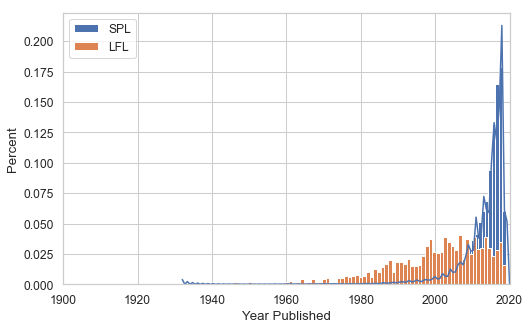

In [41]:
#'Density' Histogram of year published using mtlabplot (change kde to false for counts, or to get rid of gaussian line, change norm_hist to True)
#yrhist = bks['yrpub'].plot.hist(bins=50)
#Same thing using seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

#SPL
p1= sns.distplot(
    dfbookyr['publicationyear'], norm_hist=False, kde=True, bins=92, hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Percent')
#LFL
p1= sns.distplot(
    lflyear['yrpub'], norm_hist=True, kde=False, bins=92, hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Percent')

plt.legend(labels=['SPL','LFL'])
plt.xlim(1900, 2020)

(1900, 2020)

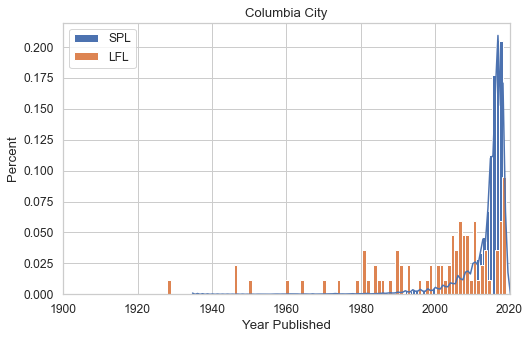

In [11]:
# BY NEIGHBORHOOD
#'Density' Histogram of year published using mtlabplot (change kde to false for counts, or to get rid of gaussian line, change norm_hist to True)
#yrhist = bks['yrpub'].plot.hist(bins=50)
#Same thing using seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

hood = "Columbia City"

#dfbookyrcol = dfbookyr[dfbookyr['itemlocation']=='col']
dfbookyrcol = dfbookyr[dfbookyr['neighborhood']==hood]
lflyearcol = lflyear[lflyear['neighborhood']==hood]

#SPL
p1= sns.distplot(
    dfbookyrcol['publicationyear'], norm_hist=False, kde=True, bins=92, hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Percent')
#LFL
p1= sns.distplot(
    lflyearcol['yrpub'], norm_hist=True, kde=False, bins=92, hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Percent')

plt.legend(labels=['SPL','LFL'])
plt.title(hood)
plt.xlim(1900, 2020)

In [42]:
dfbookyr.neighborhood.unique()

array(['Ravenna', 'Columbia City', 'Phinney-Greenwood', 'Queen Anne',
       'Central District', 'Northgate', 'Montlake'], dtype=object)

In [43]:
hoods = pd.DataFrame(dict(neighborhood=dfbookyr.neighborhood.unique()))
hoods.head()


,neighborhood
0,Ravenna
1,Columbia City
2,Phinney-Greenwood
3,Queen Anne
4,Central District


In [44]:

for h in hoods['neighborhood']:
    hood=h
    print(hood)


Ravenna
Columbia City
Phinney-Greenwood
Queen Anne
Central District
Northgate
Montlake


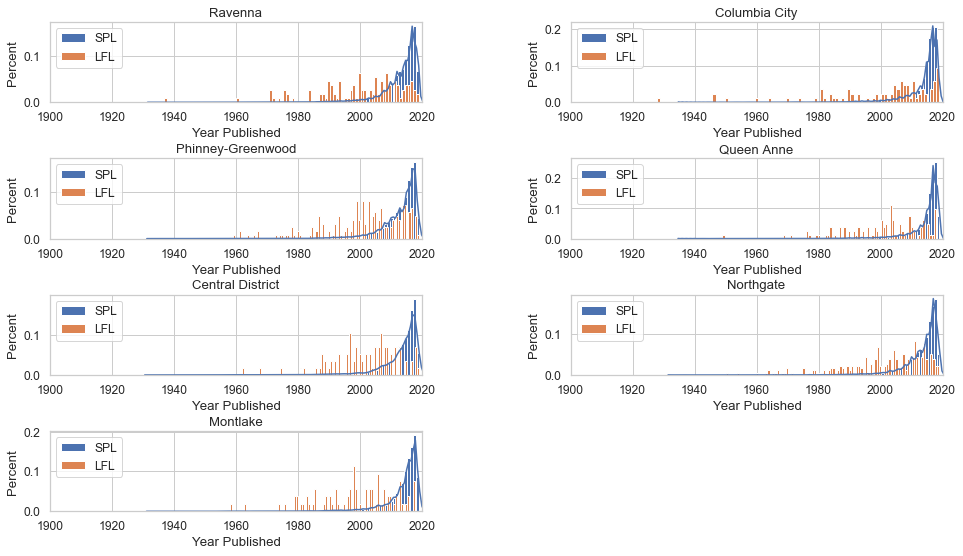

In [45]:
# BY NEIGHBORHOOD
#'Density' Histogram of year published using mtlabplot (change kde to false for counts, or to get rid of gaussian line, change norm_hist to True)
#yrhist = bks['yrpub'].plot.hist(bins=50)
#Same thing using seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

plt.rcParams["figure.figsize"] = [16,9]

# create a color palette
palette = plt.get_cmap('tab20b')

fig = plt.figure()
fig.subplots_adjust(hspace=0.7, wspace=0.4)

num=0
for h in hoods['neighborhood']:
    hood = h    
    dfbookyrcol = dfbookyr[dfbookyr['neighborhood']==hood]
    lflyearcol = lflyear[lflyear['neighborhood']==hood]
    
    num+=1
    plt.subplot(4,2, num)
    
    #SPL
    p1= sns.distplot(
        dfbookyrcol['publicationyear'], norm_hist=False, kde=True, bins=92, hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Percent')
    #LFL
    p1= sns.distplot(
        lflyearcol['yrpub'], norm_hist=True, kde=False, bins=92, hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Percent')

    plt.legend(labels=['SPL','LFL'])
    plt.title(hood)
    plt.xlim(1900, 2020)

# Set up a dataframe with SPL data by neighborhood
fiction/nonfiction, percent childrens, There is no Laurelhurst branch!!

In [46]:
dfbook.type.unique()

array(['Nonfiction', 'Fiction', 'Language', 'Reference', nan],
      dtype=object)

### Percent Fiction

In [47]:
#Set up a dataframe with the percent fiction

#Groups count by Neighborhood, and type, calculates percent
bksfiction = dfbook.groupby(['neighborhood', 'type'])['count'].sum().reset_index() #total of each category
bksfiction['total'] = bksfiction.groupby('neighborhood')['count'].transform('sum') #Inserts total count for the neighborhood for each type in each neighborhood 
bksfiction['percent'] = bksfiction['count']/bksfiction['total']


#Select fiction
fic = bksfiction.loc[bksfiction['type']=='Fiction']
fic.head(8)

,neighborhood,type,count,total,percent
0,Central District,Fiction,5485,7809,0.702395
3,Columbia City,Fiction,14870,26486,0.561429
7,Montlake,Fiction,7731,13001,0.594647
10,Northgate,Fiction,16174,27569,0.586673
14,Phinney-Greenwood,Fiction,22772,42934,0.530395
18,Queen Anne,Fiction,10197,18491,0.551457
22,Ravenna,Fiction,55198,98965,0.557753


In [48]:
fictionbks = fic['count'].sum()
totalbks = fic['total'].sum()
perfic = fictionbks/totalbks
print(perfic)

0.5629083335104461


In [49]:
test = dfbook.copy()
test['age'] = dfbook['itemtype'].str[:1]


In [50]:
#Save csv file for further testing: 
fic.to_csv('SPL-fiction.csv', mode = 'w', index=False)

### Percent Juvenile

In [51]:
dfbook.itemtype.unique()


array(['jcbk', 'acbk', 'arbk', 'jrbk', 'bcbk', 'pkbknh'], dtype=object)

In [52]:
#Set up a dataframe with the juvenile books. Uses the dfbook dataframe saved before analysis

#Groups count by Neighborhood, and itemtype, calculates percent
bksage = dfbook.groupby(['neighborhood', 'itemtype'])['count'].sum().reset_index() #total of each category
bksage['ageletter'] = bksage['itemtype'].str[:1] #selects first letter of itemtype code (a=adult and YA, j=juvenile)
bksagelist = bksage.groupby(['neighborhood','ageletter'])['count'].apply(lambda x : x.astype(int).sum()) #sums up the a's and j's by neighborhood
bksage = pd.DataFrame(bksagelist).reset_index()
bksage['total'] = bksage.groupby('neighborhood')['count'].transform('sum') #Inserts total count for the neighborhood for each type in each neighborhood

bksage['percent'] = bksage['count']/bksage['total']

bksage.head()


,neighborhood,ageletter,count,total,percent
0,Central District,a,3042,7809,0.389551
1,Central District,j,4706,7809,0.602638
2,Central District,p,61,7809,0.007811
3,Columbia City,a,14818,26486,0.559465
4,Columbia City,b,8,26486,0.000302


In [53]:
#Select juveniles
bksjuv = bksage.loc[bksage['ageletter']=='j']
bksjuv.head(8)


,neighborhood,ageletter,count,total,percent
1,Central District,j,4706,7809,0.602638
5,Columbia City,j,11587,26486,0.437476
9,Montlake,j,6266,13006,0.481778
13,Northgate,j,11591,27569,0.420436
17,Phinney-Greenwood,j,18297,42934,0.426166
21,Queen Anne,j,7791,18491,0.421340
25,Ravenna,j,39707,99347,0.399680


In [54]:
#Save csv file for further testing: 
bksjuv.to_csv('SPL-juvenilePercent.csv', mode = 'w', index=False)